In [1]:
from common.torch_utils import get_available_device

device = get_available_device()

Platform: Darwin
Release: 21.5.0
MPS available: True
CUDA available: False
Selected device: mps


## Model

In [2]:
from fcos import FCOS
from fcos import build_backbone
from dataset import LabelsCodec

target_resolution = (256, 256)
model = FCOS(
    backbone=build_backbone('resnet50'),
    labels_codec=LabelsCodec(),
    res=target_resolution,
)

## Dataloader

In [3]:
from dataset.loader import build_dataloader

train_dataloader = build_dataloader('train', batch_size=4)
img, boxes, labels = next(iter(train_dataloader))
print(img.shape)
print(boxes)
print(labels)

torch.Size([4, 256, 256, 3])
[tensor([[103.2997,  64.4955, 201.1543, 164.0259],
        [ 43.1308,  97.0003, 115.8361, 172.1490]]), tensor([[ 29.6583,   0.0000, 256.0000, 256.0000]]), tensor([[  0.0000,   0.0000, 236.6574, 256.0000],
        [ 44.2703,   0.0000, 251.4955, 226.8307],
        [185.9104,  94.0539, 235.2548, 174.0084]]), tensor([[  0.0000,   0.0000, 252.8645, 256.0000]])]
[tensor([17, 15], dtype=torch.int32), tensor([17], dtype=torch.int32), tensor([18, 18,  0], dtype=torch.int32), tensor([8], dtype=torch.int32)]


/Users/iolkhovsky/Documents/repos/fcos/dataset/loader.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  return torch.Tensor(images), bboxes, labels


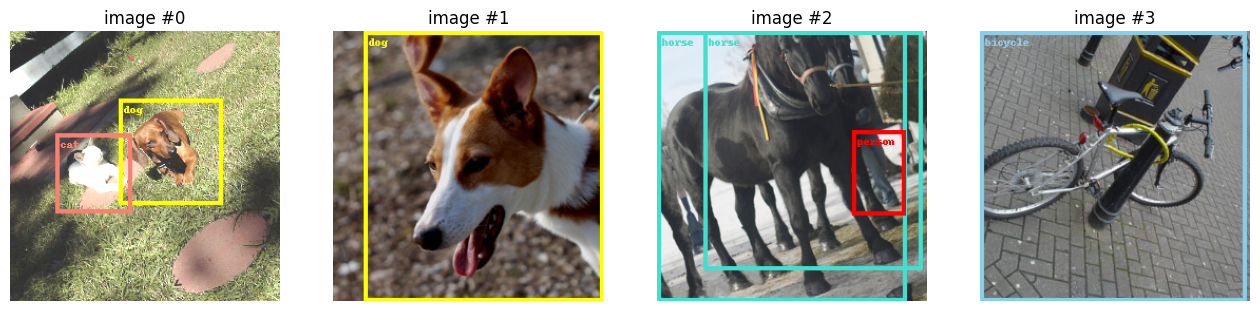

In [4]:
from dataset.visualization import visualize_batch
from dataset.labels_codec import LabelsCodec

visualize_batch(img, boxes, labels, codec=LabelsCodec())

In [5]:
pred = model(img)

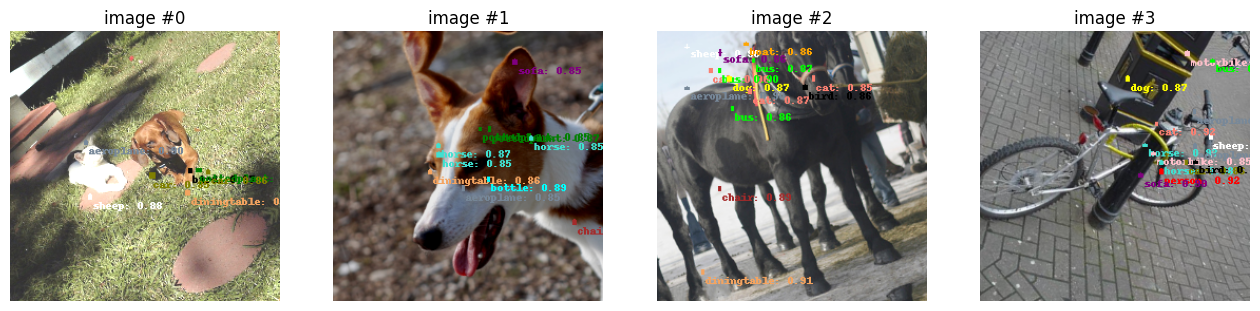

In [6]:
import torch


def draw_predictions(imgs_batch, prediction, labels_codec, threshold=0.01):  
    boxes = [[] for i in range(len(imgs_batch))]
    labels = [[] for i in range(len(imgs_batch))]
    scores = [[] for i in range(len(imgs_batch))]

    for fmap, map_pred in prediction.items():
        pred_classes = map_pred['classes']
        pred_center = map_pred['centerness']
        pred_boxes = map_pred['boxes']

        for img_idx in range(len(pred_classes)):
            img_classes = pred_classes[img_idx]
            img_centerness = pred_center[img_idx]
            img_boxes = pred_boxes[img_idx]
            
            final_scores = img_classes * img_centerness
            max_scores, max_indices = torch.max(final_scores, axis=1)
            mask = max_scores > threshold

            filtered_scores = max_scores[mask]
            filtered_labels = max_indices[mask]
            filtered_boxes = img_boxes[mask]
            
            for score, label, box in zip(filtered_scores, filtered_labels, filtered_boxes):
                scores[img_idx].append(score)
                labels[img_idx].append(label)
                boxes[img_idx].append(box)

    boxes = [
        torch.stack(img_boxes) if len(img_boxes) else torch.zeros((0, 4), dtype=torch.float)
        for img_boxes in boxes
    ]
    scores = [
        torch.stack(img_scores) if len(img_scores) else torch.zeros((0, 1), dtype=torch.float)
        for img_scores in scores
    ]  
    labels = [
        torch.stack(img_labels) if len(img_labels) else torch.zeros((0, 1), dtype=torch.float)
        for img_labels in labels
    ]

    visualize_batch(
        imgs_batch,
        boxes_batch=boxes,
        labels_batch=labels,
        scores_batch=scores,
        codec=labels_codec
    )
            


draw_predictions(img, pred, LabelsCodec(), 0.85)

## Loss function

In [7]:
from fcos import FcosDetectionsCodec
from fcos import FocalLoss, CenternessLoss, IoULoss


def total_loss(pred, target):
    # targets
    target_classes, target_centerness, target_boxes = target
    all_fmaps = list(target_classes.keys())
    
    first_map = all_fmaps[0]

    b, c, h, w = target_classes[first_map].shape
    target_classes = torch.cat(
        [
            torch.reshape(torch.permute(v, [0, 2, 3, 1]), [b, -1, c]) for k, v in target_classes.items()
        ],
        axis=1
    )

    b, c, h, w = target_centerness[first_map].shape
    target_centerness = torch.cat(
        [
            torch.reshape(torch.permute(v, [0, 2, 3, 1]), [b, -1, c]) for k, v in target_centerness.items()
        ],
        axis=1
    )

    b, c, h, w = target_boxes[first_map].shape
    target_boxes = torch.cat(
        [
            torch.reshape(torch.permute(v, [0, 2, 3, 1]), [b, -1, c]) for k, v in target_boxes.items()
        ],
        axis=1
    )

    # prediction
    pred_classes = torch.cat(
        [
            pred[map_name]['classes'] for map_name in all_fmaps
        ],
        axis=1
    )

    pred_centerness = torch.cat(
        [
            pred[map_name]['centerness'] for map_name in all_fmaps
        ],
        axis=1
    )

    pred_boxes = torch.cat(
        [
            pred[map_name]['boxes'] for map_name in all_fmaps
        ],
        axis=1
    )

    # loss
    print(f"Classes (pred / target): {pred_classes.shape} {target_classes.shape}")
    print(f"Centerness (pred / target): {pred_centerness.shape} {target_centerness.shape}")
    print(f"Boxes (pred / target): {pred_boxes.shape} {target_boxes.shape}")
    
    positive_samples = torch.sum(target_classes, axis=-1)  
    positive_mask = positive_samples > 0
    positive_samples_cnt = torch.sum(positive_mask)
    print("Positive samples cnt:", positive_samples_cnt)
    
    class_loss = FocalLoss()(
        pred_classes,
        target_classes,
    )
    class_loss = torch.sum(class_loss) / positive_samples_cnt

    pred_boxes_positive = torch.reshape(pred_boxes[positive_mask], [-1, 4])
    target_boxes_positive = torch.reshape(target_boxes[positive_mask], [-1, 4])
    pred_centerness_positive = pred_centerness[positive_mask]
    target_centerness_positive = target_centerness[positive_mask]

    centerness_loss = CenternessLoss()(
        pred_centerness_positive,
        target_centerness_positive,
    )
    centerness_loss = torch.sum(centerness_loss) / positive_samples_cnt

    regression_loss = IoULoss()(
        pred_boxes_positive,
        target_boxes_positive,
    )
    regression_loss = torch.sum(regression_loss)

    return class_loss, centerness_loss, regression_loss
    

img_res = (256, 256)
labels_codec = LabelsCodec()
codec = FcosDetectionsCodec(img_res, labels_codec)

targets = codec.encode(boxes, labels)
res = total_loss(pred, targets)
print("Loss", res)

/Users/iolkhovsky/Documents/repos/fcos/fcos/codec.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ltrb_tensor = torch.tensor(ltrb, dtype=torch.float32)


Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 1364, 4]) torch.Size([4, 1364, 4])
Positive samples cnt: tensor(82)
Loss (tensor(342.8203, grad_fn=<DivBackward0>), tensor(0.8001, grad_fn=<DivBackward0>), tensor(62.2310, grad_fn=<SumBackward0>))


## Training draft

In [ ]:
import time
import torch.optim as optim


# model = model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-3)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = total_loss


for epoch in range(1):

    for step, (img, boxes, labels) in enumerate(train_dataloader):
        start_stamp = time.time()
        optimizer.zero_grad()

#         img = img.to(device)
        pred = model(img)
        
        targets = codec.encode(boxes, labels)
#         targets = targets.to(device)

        clf_loss, cntr_loss, regr_loss = criterion(pred, targets)
        total_loss = clf_loss + cntr_loss + regr_loss
        print(f"Step {step} Total loss: {total_loss}")
        print(f"\tClassification: {clf_loss}")
        print(f"\tCenterness {cntr_loss}")
        print(f"\tRegression {regr_loss}")
        print()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 100.)
        optimizer.step()
        print(f"Step duration: {time.time() - start_stamp}")

print('Finished Training')

Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 1364, 4]) torch.Size([4, 1364, 4])
Positive samples cnt: tensor(70)
Step 0 Total loss: 454.4508056640625
	Classification: 400.303466796875
	Centerness 0.8156320452690125
	Regression 53.33170700073242

Step duration: 9.191143989562988
Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 1364, 1])
Boxes (pred / target): torch.Size([4, 1364, 4]) torch.Size([4, 1364, 4])
Positive samples cnt: tensor(49)
Step 1 Total loss: 606.0239868164062
	Classification: 573.2506103515625
	Centerness 0.8054046034812927
	Regression 31.96795654296875

Step duration: 9.240705013275146
Classes (pred / target): torch.Size([4, 1364, 20]) torch.Size([4, 1364, 20])
Centerness (pred / target): torch.Size([4, 1364, 1]) torch.Size([4, 